The best C value is: 3
Cross-validation scores: [1.         1.         0.88888889 1.         0.94444444]
Mean cross-validation score: 0.967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



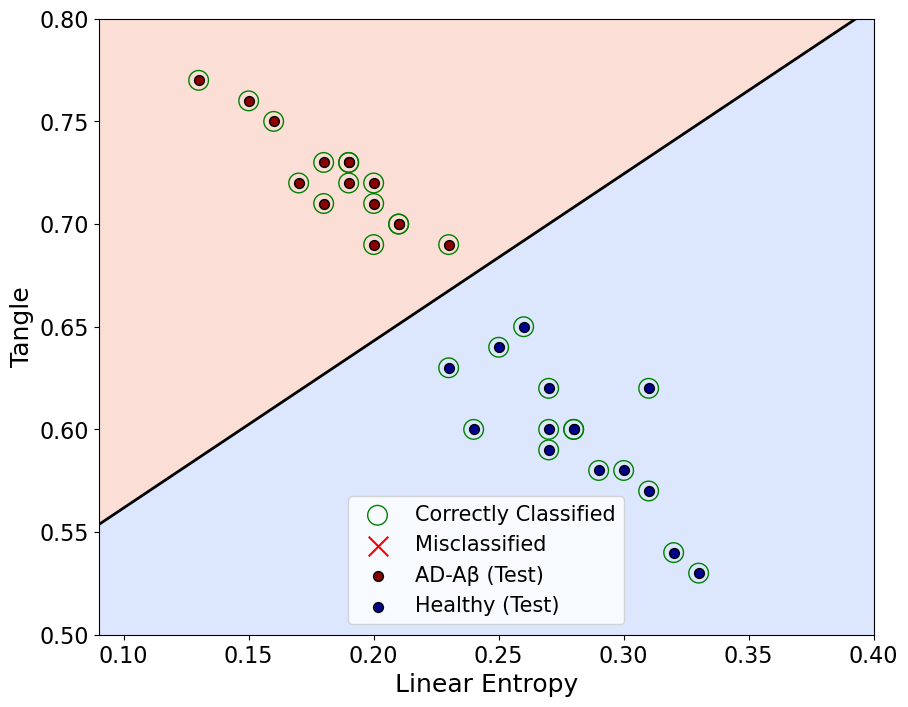

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Training dataset
file_path_train = 'Tr_DC_234_FAD.xlsx' 
data_train = pd.read_excel(file_path_train)

X_train = data_train[['Linear entropy', 'Tangle']].values
y_train = data_train['Label'].values

# Test dataset with labels
file_path_test = 'T_DC_1_FAD.xlsx'
test_data_with_labels = pd.read_excel(file_path_test)

# Features and labels from the test data
X_test_new = test_data_with_labels[['Linear entropy', 'Tangle']].values  # Test features
y_test_new = test_data_with_labels['Label'].values  # True labels

# Parameter grid for GridSearchCV
param_grid = {'C': np.arange(1,10,1)}

# Grid search with 5-fold cross-validation on training data
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get best C value from  grid search
best_c = grid_search.best_params_['C']
print(f"The best C value is: {best_c}")

# Get the best estimator (model with the optimal C)
best_model = grid_search.best_estimator_

# Use the trained model to predict the labels of the test data
y_pred_test = best_model.predict(X_test_new)

# Plotting the test data, comparing true vs predicted labels
def plot_test_data_comparison(X_test_new, y_test_new, y_pred_test, model):
    plt.figure(figsize=(10, 8))

    #Separating hyperplane
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(X_test_new[:, 0].min() - 1, X_test_new[:, 0].max() + 1)
    yy = a * xx - (model.intercept_[0]) / w[1]

    
    xx_grid, yy_grid = np.meshgrid(np.linspace(X_test_new[:, 0].min() - 1, X_test_new[:, 0].max() + 1, 500),
                                   np.linspace(X_test_new[:, 1].min() - 1, X_test_new[:, 1].max() + 1, 500))
    Z = model.decision_function(np.c_[xx_grid.ravel(), yy_grid.ravel()])
    Z = Z.reshape(xx_grid.shape)

    # Plot decision boundary 
    plt.contourf(xx_grid, yy_grid, Z, levels=[Z.min(), 0, Z.max()], alpha=0.3, cmap=plt.cm.coolwarm)

    # Correctly classified points
    plt.tick_params(labelsize=16)
    correct = y_pred_test == y_test_new
    plt.scatter(X_test_new[correct, 0], X_test_new[correct, 1], facecolors='none', edgecolor='green', s=200, label='Correctly Classified')

    # Misclassified points 
    plt.scatter(X_test_new[~correct, 0], X_test_new[~correct, 1], marker='x', c='red', s=200, label='Misclassified')

    # Plot the test data points (predicted labels)
    plt.xlim(0.09, 0.4)
    plt.ylim(0.5, 0.8)
    plt.scatter(X_test_new[y_pred_test == 1, 0], X_test_new[y_pred_test == 1, 1], c='darkred', label='AD-Aβ (Test)', s=50, edgecolor='k')
    plt.scatter(X_test_new[y_pred_test == 0, 0], X_test_new[y_pred_test == 0, 1], c='darkblue', label='Healthy (Test)', s=50, edgecolor='k')
    
    # Plot the hyperplane 
    plt.plot(xx, yy, 'k-', linewidth=2) #, label='Decision Boundary'
    plt.xlabel('Linear Entropy', fontsize=18)
    plt.ylabel('Tangle', fontsize=18)
    plt.legend(fontsize=15)

    
# Plot test data comparison between true and predicted labels
plot_test_data_comparison(X_test_new, y_test_new, y_pred_test, best_model)

# Save plot
#fig = plt.gcf()
#fig.savefig('Test_SVM_Cortex1_FAD.svg')
#fig.savefig('Test_SVM_Cortex1_FAD.pdf')

#k-fold cross-validation on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=kf)

# Print the cross-validation scores and the mean score
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean():.3f}')

#Compute performance
print(classification_report(y_test_new, y_pred_test))

